<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.naive_bayes import GaussianNB

Пропуски обнаружены в столбце Tenure, пропусков ~ 10%. Столбцы Surname, Geography, Gender являются нечисловыми.

In [2]:
data = pd.read_csv('Churn_Modelling.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Я выдвинул гипотезу о том, что кол-во продуктов банка, которые использует клиент, связано с длительностью их сотрудничества. Она оказалась неверна - в среднем клиенты сотрудничают с банком 5 лет, внезависимости от кол-ва используемых продуктов. На гистограммах аномалий выявлено не было.

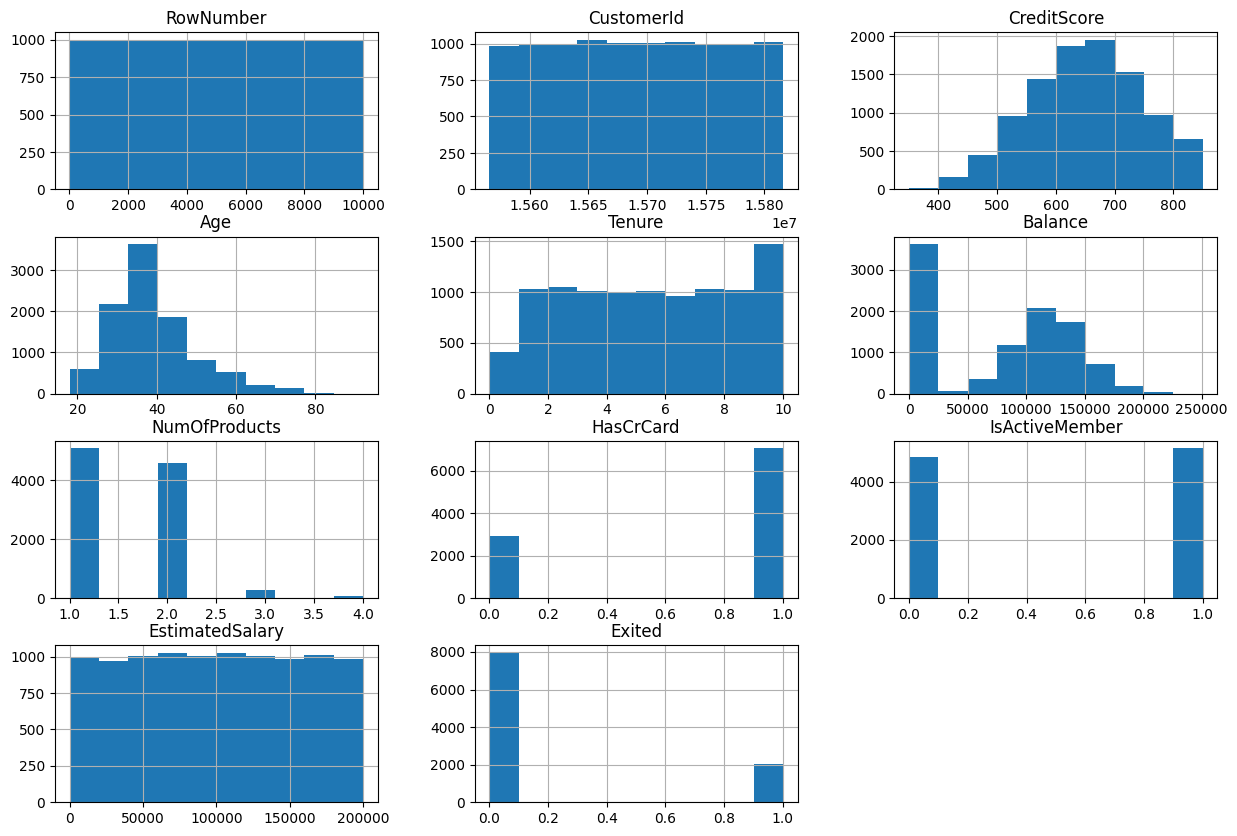

In [3]:
#print(data.groupby(by ='NumOfProducts')['Tenure'].mean())
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data.hist(figsize = (15,10))
plt.show()

Удалены столбцы RowNumber, CustomerId, Surname ввиду их непригодности для дальнейшего анализа. Также произведено one_hot кодирование.

In [4]:
data = data.drop('RowNumber', axis = 1)
data = data.drop('CustomerId', axis = 1)
data = data.drop('Surname', axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [5]:
transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), ['Geography', 'Gender']),
    remainder='passthrough')

transformed = transformer.fit_transform(data)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
columns=transformer.get_feature_names_out()


Разделим данные на тренировочную, валидационую, тестовую выборки, в следующем соотношении: 0.7:0.18:0.12

In [6]:
data = transformed_df

In [7]:
X = data.drop('remainder__Exited',axis = 1)
Y = data['remainder__Exited']

In [8]:
X_train, x1, Y_train, y1 = train_test_split(X,Y,test_size = 0.3, random_state = 12345)
X_valid, X_test, Y_valid, Y_test = train_test_split(x1,y1,test_size = 0.4, random_state = 12345)
print(X_valid.shape, X_test.shape, X_train.shape)

(1800, 11) (1200, 11) (7000, 11)


In [9]:
X.columns

Index(['onehotencoder__Geography_Germany', 'onehotencoder__Geography_Spain',
       'onehotencoder__Gender_Male', 'remainder__CreditScore',
       'remainder__Age', 'remainder__Tenure', 'remainder__Balance',
       'remainder__NumOfProducts', 'remainder__HasCrCard',
       'remainder__IsActiveMember', 'remainder__EstimatedSalary'],
      dtype='object')

In [10]:
# масштабирование признаков

columns = ['remainder__CreditScore', 'remainder__Age', 'remainder__Tenure', 'remainder__Balance', 'remainder__NumOfProducts', 'remainder__EstimatedSalary']

scaler = StandardScaler()
scaler.fit(X_train[columns])
X_train[columns] = scaler.transform(X_train[columns])
X_valid[columns] = scaler.transform(X_valid[columns])
X_test[columns] = scaler.transform(X_test[columns])

X_train.head()

,onehotencoder__Geography_Germany,onehotencoder__Geography_Spain,onehotencoder__Gender_Male,remainder__CreditScore,remainder__Age,remainder__Tenure,remainder__Balance,remainder__NumOfProducts,remainder__HasCrCard,remainder__IsActiveMember,remainder__EstimatedSalary
9716,1.0,0.0,1.0,1.658077,0.012853,-0.015085,0.635477,2.527132,1.0,1.0,1.480907
224,1.0,0.0,1.0,0.198643,0.584111,0.332263,0.375870,-0.895510,1.0,1.0,0.153167
589,0.0,1.0,0.0,-1.374648,0.774530,0.332263,1.302947,0.815811,0.0,0.0,0.817773
7507,1.0,0.0,1.0,-0.784664,0.488901,1.374307,0.696496,-0.895510,1.0,0.0,0.329403
1457,0.0,0.0,1.0,2.051400,2.583513,-0.362433,-1.222967,0.815811,0.0,1.0,-0.617269


## Исследование задачи

Определим количество деревьев в модели случайного леса, необходимых для достижения максимального значения метрик f1 и roc_auc.

In [11]:
f1 = 0
f1_i = 0
f1_j = 0
auc = 0
auc_i = 0
auc_j = 0
for i in range(15,35, 1):
    for j in range (1,20,2):
        model = RandomForestClassifier(random_state = 12345, n_estimators = i, max_depth = j)
        model.fit(X_train, Y_train)
        RF_f1 = f1_score(Y_valid,model.predict(X_valid))
        RF_auc = roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1])
        if RF_f1 >= f1:
            f1 = RF_f1
            f1_j = j    
            f1_i = i
        if RF_auc >= auc:
            auc = RF_auc
            auc_j = j    
            auc_i = i
print('F1=', f1, f1_j, f1_i)
print('roc_auc = ', auc, auc_j, auc_i)

F1= 0.5970636215334422 19 31
roc_auc =  0.8540500584795323 7 20


Вывод: наилучшая модель случайного леса, которую получилось создать, имеет следующие гиперпараметры: n_estimators = 31, max_depth = 19. При этом f1 = 0.6. Если оценивать модель по метрике roc_auc_score , то наилучшие параметры: n_estimators = 20, max_depth = 7, roc_auc_score = 0.85

Определим оптимальную величину максимальной глубины модели дерева решений.

In [12]:
auc = 0
auc_j = 0
f1 = 0
f1_j = 0
for j in range(1,100, 10):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = j)
    model.fit(X_train, Y_train)
    DTC_f1 = f1_score(Y_valid,model.predict(X_valid))
    DTC_ra = roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1])
    if DTC_ra >= auc:
        auc = DTC_ra
        auc_j = j
    if DTC_f1 >= f1:
        f1 = DTC_f1
        f1_j = j
print('auc_roc = ', auc, auc_j)  
print('F1 = ', DTC_f1, f1_j)

auc_roc =  0.7214063157894737 11
F1 =  0.4959568733153638 11


Вывод: наилучшая модель дерева решений, которую получилось создать, имеет следующие гиперпараметры: max_depth = 11. При этом f1 = 0.51, roc_auc = 0.72

Определим оптимальное величину max_iter для модели логистической регрессии.

In [13]:
f1 = 0
auc = 0
f1_i = 0
auc_i = 0
for i in range(4000,5000, 100):
    model = LogisticRegression(solver = 'liblinear', random_state =12345,max_iter = i)
    model.fit(X_train, Y_train)
    Lin_f1 = f1_score(Y_valid,model.predict(X_valid))
    Lin_ra = roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1])
    if Lin_f1 >= f1:
        f1 = Lin_f1
        f1_i = i
    if Lin_ra >= auc:
        auc = Lin_ra
        auc_i = i
print('F1 = ', Lin_f1,f1_i)
print('roc_auc = ', auc,auc_i)

F1 =  0.32504780114722753 4900
roc_auc =  0.7631719298245615 4900


In [29]:
model = GaussianNB()
model.fit(X_train, Y_train)
gauss_f1 = f1_score(Y_valid,model.predict(X_valid))
gauss_ra = roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1])
print('F1 = ', gauss_f1)
print('roc_auc = ', gauss_ra)

F1 =  0.4249578414839798
roc_auc =  0.7852388304093567


Показатели f1 = 0.06 и roc_auc = 0.67 говорят о том, что такая модель предсказывает с точностью cлучайного ответа для каждого случая

Вывод: наилучшая модель - случайный лес. n_estimators = 31, max_depth = 15, f1 = 0.6.

## Борьба с дисбалансом

In [15]:
f1_i = 0
f1 = 0
auc_i = 0
auc = 0
for i in range (2000,3000,100):
    model = LogisticRegression(random_state = 12345, max_iter = i, solver = 'liblinear', class_weight = 'balanced')
    model.fit(X_train, Y_train)
    LR_f1 = f1_score(Y_valid,model.predict(X_valid))
    LR_auc = roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1])
    if LR_f1 >= f1:
        f1 = LR_f1
        f1_i = i
    if LR_auc >= auc:
        auc = LR_auc
        auc_i = i
print('F1 = ', f1, f1_i)
print('auc = ', auc, auc_i)

F1 =  0.4967320261437908 2900
auc =  0.767485380116959 2900


In [16]:
f1 = 0
f1_i = 0
f1_j = 0
auc = 0
auc_i = 0
auc_j = 0
for i in range(15,35, 1):
    for j in range (1,20,2):
        model = RandomForestClassifier(random_state = 12345, n_estimators = i, max_depth = j, class_weight = 'balanced')
        model.fit(X_train, Y_train)
        RF_f1 = f1_score(Y_valid,model.predict(X_valid))
        RF_auc = roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1])
        if RF_f1 >= f1:
            f1 = RF_f1
            f1_j = j    
            f1_i = i
        if RF_auc >= auc:
            auc = RF_auc
            auc_i = i
            auc_j = j

print('F1 = ', f1, f1_j, f1_i)
print('auc = ', auc, auc_j, auc_i)

F1 =  0.6330390920554855 9 34
auc =  0.8541239766081872 7 25


In [17]:
f1_i = 0
f1 = 0
auc = 0
auc_i = 0
for i in range (5000,7000,100):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = i, class_weight = 'balanced')
    model.fit(X_train, Y_train)
    DTC_f1 = f1_score(Y_valid,model.predict(X_valid))
    DTC_auc = roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1])
    if DTC_f1 >= f1:
        f1 = DTC_f1
        f1_i = i
    if DTC_auc >= auc:
        auc = DTC_auc
        auc_i = i
print('F1 = ', f1, f1_i)
print('auc = ', auc, auc_i)

F1 =  0.47476125511596173 6900
auc =  0.667438596491228 6900


При борьбе с дисбалансом классов с помощью метода взвешенных классов (class_weight = 'balanced') наилучшую точность показала модель случайного леса, n_estimators = 34, max_depth = 9

In [18]:
Y.sum()/len(Y)

0.2037

Целевой признак == 1 встречается в 4 раз реже , чем целевой признак == 0, следовательно , примення upsampling, нужно увеличить кол-во классов,у которых целевой признак == 1, в 4 раза

In [19]:
features_train, x1, target_train, y1 = train_test_split(
    X, Y, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(x1,y1,test_size = 0.3, random_state = 12345)
def upsample(X, Y, repeat):
    features_zeros = X[Y == 0]
    features_ones = X[Y == 1]
    target_zeros = Y[Y == 0]
    target_ones = Y[Y == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)


In [20]:
target_upsampled.sum()/len(target_upsampled)

0.49895702962035876

Проблема с дисбалансом классов решена!

Найдем оптимальные гиперпараметры и рассчитаем метрику F1 для каждой модели(обученной на преобразованных данных) на тестовой выборке.

In [21]:
f1_i = 0
f1 = 0
auc_i = 0
auc = 0
for i in range (2000,3000,100):
    model = LogisticRegression(random_state = 12345, max_iter = i, solver = 'liblinear')
    model.fit(features_upsampled, target_upsampled)
    LR_f1 = f1_score(target_valid,model.predict(features_valid))
    LR_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
    if LR_f1 >= f1:
        f1 = LR_f1
        f1_i = i
    if LR_auc >= auc:
        auc = LR_auc
        auc_i = i
print('F1 = ', f1, f1_i)
print('auc = ', auc, auc_i)

F1 =  0.4385150812064965 2900
auc =  0.7073983074413186 2900


In [22]:
f1 = 0
f1_i = 0
f1_j = 0
auc = 0
auc_i = 0
auc_j = 0
for i in range(15,35, 1):
    for j in range (1,20,2):
        model = RandomForestClassifier(random_state = 12345, n_estimators = i, max_depth = j)
        model.fit(features_upsampled, target_upsampled)
        RF_f1 = f1_score(target_valid,model.predict(features_valid))
        RF_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
        if RF_f1 >= f1:
            f1 = RF_f1
            f1_j = j    
            f1_i = i
        if RF_auc >= auc:
            auc = RF_auc
            auc_i = i
            auc_j = j

print('F1 = ', f1, f1_j, f1_i)
print('auc = ', auc, auc_j, auc_i)

F1 =  0.6118299445471349 15 33
auc =  0.8565149644843115 7 25


In [23]:
f1_i = 0
f1 = 0
auc = 0
auc_i = 0
for i in range (5000,7000,100):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = i)
    model.fit(features_upsampled, target_upsampled)
    DTC_f1 = f1_score(target_valid,model.predict(features_valid))
    DTC_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
    if DTC_f1 >= f1:
        f1 = DTC_f1
        f1_i = i
    if DTC_auc >= auc:
        auc = DTC_auc
        auc_i = i
print('F1 = ', f1, f1_i)
print('auc = ', auc, auc_i)

F1 =  0.4893617021276596 6900
auc =  0.6791062823814299 6900


Вывод: наилучшей моделью для решения этой задачи при помощи upsampling является случайный лес. Максимальная метрика f1 = 0.611 на тестовой выборке.

Итог работы с дисбалансом классов: лучшая модель - случайный лес , дисбаланс классов обрабатывается при помощи class_weight = 'balanced', параметры: max_depth = 15, n_estimators = 33, f1 = 0.611, roc_auc_score = 0.856

## Тестирование модели

In [24]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 34, max_depth = 9, class_weight = 'balanced')
model.fit(X_train, Y_train)
print("F1 = ", f1_score(Y_test, model.predict(X_test)))
print("AUC_ROC = ", roc_auc_score(Y_test, model.predict_proba(X_test)[:,1]))

F1 =  0.6429906542056074
AUC_ROC =  0.8653017015184783


In [25]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
DummyClassifier(strategy='most_frequent')
dummy_clf.score(features_test, target_test)

0.7733333333333333

Модель случайного леса предсказывает на 9% точнее, чем константная модель.

Итоги проделанной работы:
1) проведена предобработка данных
2) проведено сравнение трех моделей машинного обучения по двум метрикам (f1_score, roc_auc_score)
3) опробованы два метода борьбы с дисбалансом классов (взвешивание классов, upsampling), лучшую точность на двух метриках (F1_score, roc_auc_score) показало взвешивание классов
4) проведено тестирование итоговой модели
Результатом проекта является модель случайного леса, показавшая F1= 0.638, roc_auc_score = 0.864 на тестовой выборке, борьба с дисбалансом классов проводится через их взвешивание